In [ ]:
import os
os.kill(os.getpid(), 9)

Installing Library to read .dcm format for medical images.

In [1]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.0 MB/s eta 0:00:00


Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Required Libraries

In [1]:
import os
import cv2
import random
import pathlib 
import numpy as np
import tensorflow as tf
from google.colab import files

import pydicom
from pydicom import dcmread

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix



Assigning Empty lists

In [2]:
covid = []
non_covid = []
label1 = []
label0 = []
data = []
data0 = []
data1 = []
labels = []
c = 0
c1 = 0


Reading data having just the images of COVID-19 affected scans from the drive.

In [3]:
# Using os.walk()
for root, dirs, files in os.walk(r"/content/drive/MyDrive/Data/covid19", topdown=True):
   for name in files:
      ct_scan = pydicom.dcmread(os.path.join(root,name))
      ct_s = ct_scan.pixel_array
      #resize and normalize
      try:
          ct=cv2.resize(ct_s,(100,100)) / 255.0
          covid.append(ct)
      except:
          c+=1
          continue
print("Number of Covid images skipped = ",c)    
covid = np.asarray(covid)
print(covid.shape)

Number of Covid images skipped =  0
(20149, 100, 100)


Reshaping the data:

In [4]:
covid1 = np.reshape(covid, (covid.shape[0],10000))
covid1 = np.append(covid1, np.ones((covid.shape[0],1)), axis = 1)
print(covid1.shape)

(20149, 10001)


Splitting the data:
70% Train
15% Cross-Validation
15% Test

In [5]:
covid_train, covid_test = train_test_split(covid1, test_size = 0.3, shuffle=False)

#spltting test data into cv and test
covid_test = covid1[covid_train.shape[0]:covid1.shape[0],:]
covid_cv = covid_test[0:int((covid_test.shape[0]*0.5)),:]
covid_test = covid_test[covid_cv.shape[0]:covid_test.shape[0],:]
print(covid_train.shape)
print(covid_cv.shape)
print(covid_test.shape)

(14104, 10001)
(3022, 10001)
(3023, 10001)


Displaying the samples of data

Covid Patient Scans
(20149, 100, 100)


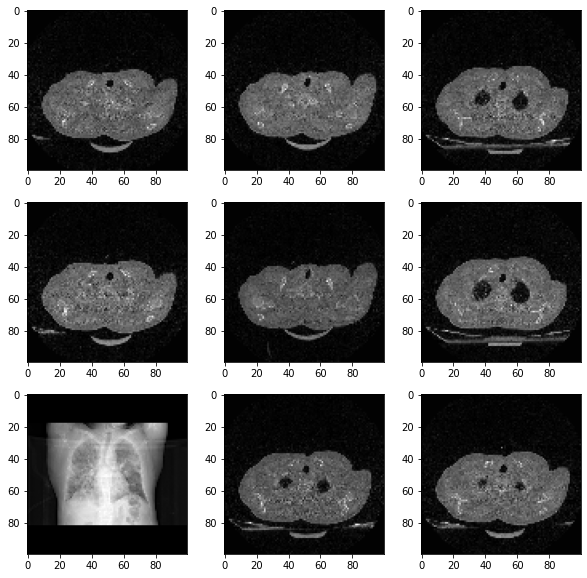

In [6]:
#printing images of covid patients
print("Covid Patient Scans")
data1 = np.asarray(covid)
label1 = np.asarray(label1)
scan = data1.shape
print(scan)

fig, axis = plt.subplots(3, 3, figsize = (10, 10))
slice_counter = 0
for i in range(3):
  for j in range(3):
    axis[i][j].imshow(data1[slice_counter], cmap = "gray")
    slice_counter += 1

Reading data of normal scans (non-COVID-19) from drive:

In [7]:
for root, dirs, files in os.walk(r"/content/drive/MyDrive/Data/non-covid", topdown=True):
   for name in files:
      norm_scan = pydicom.dcmread(os.path.join(root,name))
      normal_scan = norm_scan.pixel_array
      try:
          norm=cv2.resize(normal_scan,(100,100)) / 255.0
          non_covid.append(norm)
          label0.append(0)
      except:
          c1+=1
          continue
print("Number of non-covid images skipped= ",c1)
      #ct_s = cv2.resize(ct_s,IMAGE_SIZE)
      #images.append(ct_s)      

Number of non-covid images skipped=  0


Displaying the samples of non-COVID data:

Non-Covid Patient Scans
(6976, 100, 100)


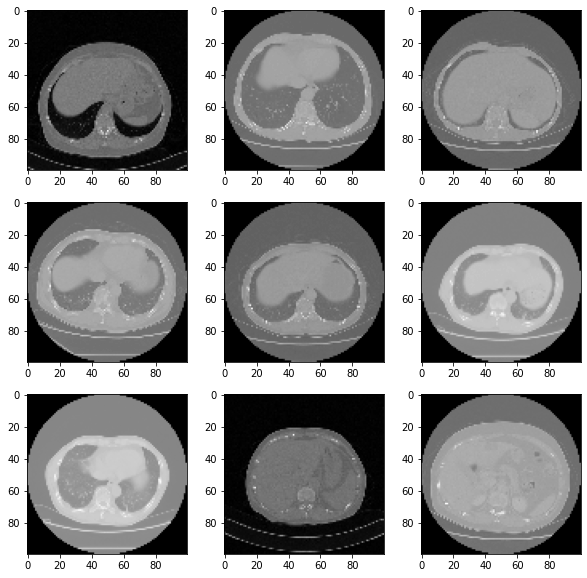

In [8]:
print("Non-Covid Patient Scans")
data0 = np.asarray(non_covid)
label0 = np.asarray(label0)
scan = data0.shape
print(scan)


fig, axis = plt.subplots(3, 3, figsize = (10, 10))
slice_counter = 0
for i in range(3):
  for j in range(3):
    axis[i][j].imshow(data0[slice_counter], cmap = "gray")
    slice_counter += 1

In [9]:
normal = np.asarray(non_covid)
print(normal.shape)

(6976, 100, 100)


Reshaping the data:

In [10]:
non_covid = np.reshape(data0, (data0.shape[0],10000))
non_covid = np.append(non_covid, np.zeros((non_covid.shape[0],1)), axis = 1)
print(non_covid.shape)

(6976, 10001)


Splitting the data:

In [11]:
non_covid_train, non_covid_test = train_test_split(non_covid, test_size = 0.3, shuffle=False)

non_covid_test = non_covid[non_covid_train.shape[0]:non_covid.shape[0],:]
non_covid_cv = non_covid_test[0:int((non_covid_test.shape[0]*0.5)),:]
non_covid_test = non_covid_test[non_covid_cv.shape[0]:non_covid_test.shape[0],:]
print(non_covid_train.shape)
print(non_covid_cv.shape)
print(non_covid_test.shape)

(4883, 10001)
(1046, 10001)
(1047, 10001)


Appending the dataset:

In [12]:
data_train = np.append(covid_train, non_covid_train, axis = 0)
data_cv = np.append(covid_cv, non_covid_cv, axis = 0)
data_test = np.append(covid_test, non_covid_test, axis = 0)
print('Training Data Shape:',data_train.shape)
print('Cross-Validation Data Shape:',data_cv.shape)
print('Testing Data Shape:',data_test.shape)

Training Data Shape: (18987, 10001)
Cross-Validation Data Shape: (4068, 10001)
Testing Data Shape: (4070, 10001)


In [13]:
np.random.shuffle(data_train)
np.random.shuffle(data_cv)
np.random.shuffle(data_test)

Splitting data into X and Y

In [14]:
X_train = data_train[:,0:-1]
X_cv = data_cv[:,0:-1]
X_test = data_test[:,0:-1]
y_train = data_train[:,[data_train.shape[1]-1]]
y_cv = data_cv[:,[data_cv.shape[1]-1]]
y_test = data_test[:,[data_test.shape[1]-1]]

In [ ]:
from numpy import savetxt
savetxt('Xdata.csv', X_test, delimiter=',')

In [ ]:
savetxt('ydata.csv', y_test, delimiter=',')

Reshaping the Data for ImageDataGenerator

In [15]:
X_train = X_train.reshape(X_train.shape[0],100,100,1)
X_cv = X_cv.reshape(X_cv.shape[0],100,100,1)
X_test = X_test.reshape(X_test.shape[0],100,100,1)

Preparing the data using Image generator

In [16]:
datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 90,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

data_train = datagen.flow(x=X_train,
                                     y=y_train,
                                     batch_size=32,
                                     shuffle=True,)
data_cv = datagen.flow(x=X_cv,
                                     y=y_cv,
                                     batch_size=32,
                                     shuffle=True,)
data_test = datagen.flow(x=X_test,
                                     y=y_test,
                                     batch_size=32,
                                     shuffle=True,)

# data_cv = ImageDataGenerator(rescale=1/255.0).flow(X_cv.reshape(X_cv.shape[0],100,100,1),y_cv,batch_size=32)
# data_test = ImageDataGenerator(rescale=1/255.0).flow(X_test.reshape(X_test.shape[0],100,100,1),y_test,batch_size=64)


In [18]:
# del covid
# del covid1
# del non_covid
del covid_train
del non_covid_train
del covid_test
del non_covid_test
del covid_cv
del non_covid_cv

**Building the Model**

In [34]:
#Registeration number = 362940
#reversed reg number = 159373 (Even numbers converted to odds)

activation = tf.keras.layers.LeakyReLU(alpha=0.1)
model = Sequential()
    
#last_layer,
model.add(Conv2D(32, (1, 1), activation=activation, padding='same',input_shape=(100,100,1)))
model.add(BatchNormalization())
    
model.add(Conv2D(64, (5, 5), activation=activation, padding='same'))
#tf.keras.layers.BatchNormalization(),
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (9, 9), activation=activation, padding='same'))
# model.add(BatchNormalization())
    
model.add(Conv2D(256, (3, 3), activation=activation, padding='same'))
#tf.keras.layers.BatchNormalization()
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (7,7), activation=activation, padding='same'))
#tf.keras.layers.BatchNormalization(),
    
model.add(Conv2D(64, (3, 3), activation=activation, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.1))

# Fully Connected Block

model.add(Flatten())
model.add(Dense(32,activation='relu'))
#tf.keras.layers.Dense(8,activation='relu'),
model.add(Dense(1,activation='sigmoid'))
    


Building model and Printing Summary 

In [35]:
model.build(input_shape=(100,100,1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 100, 100, 32)      64        
                                                                 
 batch_normalization_2 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 100, 100, 64)      51264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 50, 50, 128)       663680    
                                                                 
 conv2d_15 (Conv2D)          (None, 50, 50, 256)      

Compiling the Model

In [36]:
#compile model:
import tensorflow as tf
optimizer = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer ,loss=['binary_crossentropy'],metrics=['accuracy'])
print(X_train.shape)
print(y_train.shape)

(18987, 100, 100, 1)
(18987, 1)


Defining callback

In [37]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

Traiing the Model

In [38]:
history=model.fit(data_train, validation_data=data_cv, epochs=20, callbacks=callbacks, shuffle=True)

Epoch 1/20
  6/594 [..............................] - ETA: 50s - loss: 0.6380 - accuracy: 0.8125

594/594 [==============================] - 56s 93ms/step - loss: 0.2462 - accuracy: 0.9146 - val_loss: 0.3572 - val_accuracy: 0.8798
Epoch 2/20
594/594 [==============================] - 54s 91ms/step - loss: 0.1598 - accuracy: 0.9418 - val_loss: 0.2075 - val_accuracy: 0.9351
Epoch 3/20
594/594 [==============================] - 54s 91ms/step - loss: 0.1150 - accuracy: 0.9589 - val_loss: 0.1952 - val_accuracy: 0.9277
Epoch 4/20
594/594 [==============================] - 55s 92ms/step - loss: 0.1056 - accuracy: 0.9641 - val_loss: 0.2227 - val_accuracy: 0.9405
Epoch 5/20
594/594 [==============================] - 54s 90ms/step - loss: 0.0955 - accuracy: 0.9659 - val_loss: 0.3091 - val_accuracy: 0.8719
Epoch 6/20
594/594 [==============================] - 54s 90ms/step - loss: 0.0871 - accuracy: 0.9689 - val_loss: 0.2505 - val_accuracy: 0.8970
Epoch 7/20
594/594 [==============================] - 55s 93ms/step - loss: 0.0767 - accuracy: 0.9730 - val_loss: 0.1516 - val_accuracy: 0.9476
Epo

Plotting the loss graph

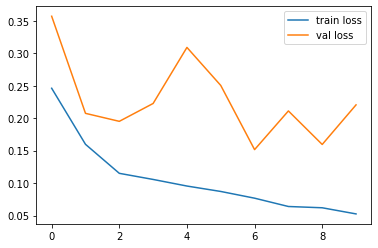

In [39]:
#loss graph
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()

Plotting the accuracy graph

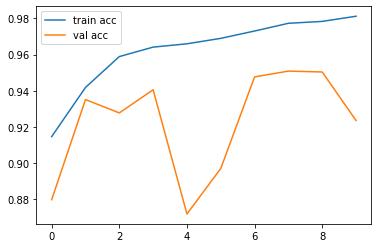

In [40]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

Saving the model in drive for predicion

In [41]:
model.save("/content/drive/MyDrive/covid19-detection-1.h5")

**PREDICTION**

Importing trained model

In [43]:
saved_model = '/content/drive/MyDrive/covid19-detection-1.h5'
saved_model = tf.keras.models.load_model(saved_model)

In [44]:
saved_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 100, 100, 32)      64        
                                                                 
 batch_normalization_2 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 100, 100, 64)      51264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 50, 50, 128)       663680    
                                                                 
 conv2d_15 (Conv2D)          (None, 50, 50, 256)      

Installing visual keras library to draw model architecture

In [45]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 41.6 MB/s eta 0:00:00


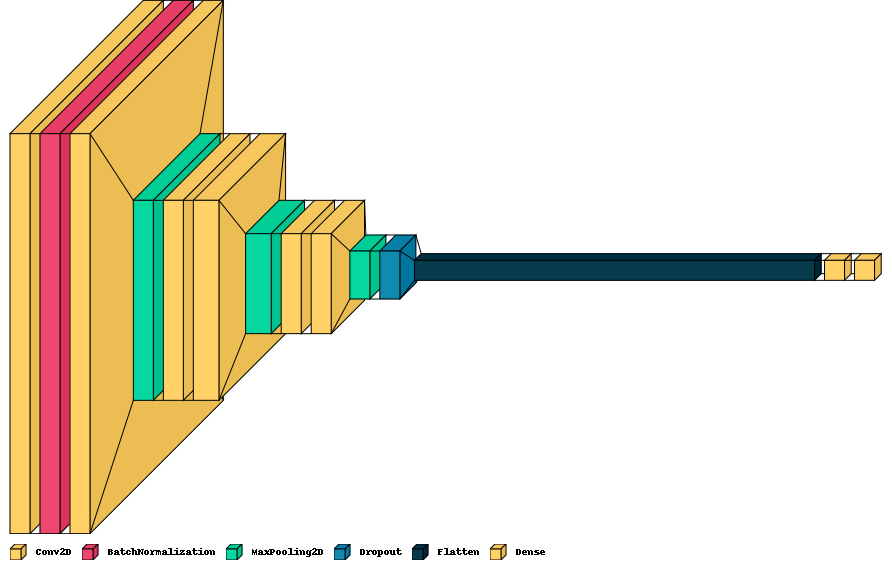

In [47]:
import visualkeras
visualkeras.layered_view(saved_model,legend=True)

Importing the test data

In [8]:
import pandas as pd
X_test = pd.read_csv('/content/drive/MyDrive/Xdata.csv')
y_test = pd.read_csv('/content/drive/MyDrive/ydata.csv')
X_test.shape, y_test.shape

((4459, 10000), (4459, 1))

In [9]:
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0],100,100,1)

Generating Confusion Matrix

In [48]:
y_pred= saved_model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_pred,y_test))
cf = confusion_matrix(y_pred,y_test)

128/128 [==============================] - 4s 29ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.26      0.41      4070
         1.0       0.00      0.00      0.00         0

    accuracy                           0.26      4070
   macro avg       0.50      0.13      0.20      4070
weighted avg       1.00      0.26      0.41      4070



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Visualizing Confusion Matrix

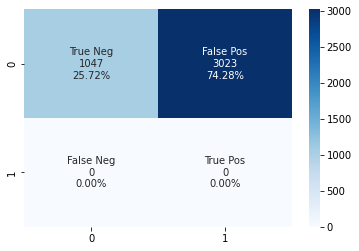

In [50]:
import seaborn as sns
# sns.heatmap(cf, annot=True)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')